# Part 1 - Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

First we convert the json file to a dataframe

In [2]:
df = pd.read_json("ultimate_data_challenge.json")
len(df)

50000

In [3]:
logins = pd.read_json("logins.json")

In [4]:
import datetime

In [5]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


Are there any NaNs?

In [6]:
logins.isnull().values.any()

False

Looks like we are good to reformat this by the count at 15 minute intervals.

In [7]:
logins_count = logins.resample('15T', on='login_time').count()

In [8]:
logins.shape

(93142, 1)

In [9]:
logins.dtypes

login_time    datetime64[ns]
dtype: object

In [10]:
logins.describe

<bound method NDFrame.describe of                login_time
0     1970-01-01 20:13:18
1     1970-01-01 20:16:10
2     1970-01-01 20:16:37
3     1970-01-01 20:16:36
4     1970-01-01 20:26:21
...                   ...
93137 1970-04-13 18:50:19
93138 1970-04-13 18:43:56
93139 1970-04-13 18:54:02
93140 1970-04-13 18:57:38
93141 1970-04-13 18:54:23

[93142 rows x 1 columns]>

In [11]:
logins_count.head()

,login_time
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


<AxesSubplot:xlabel='login_time'>

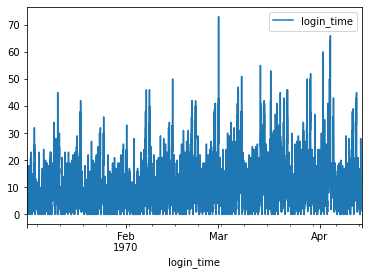

In [12]:
logins_count.plot()

Clearly there is a lot of seasonality in this data, but by what interval?  I'm going to look at a week of data to see how it varies per day.

In [13]:
m1 = logins_count.index > '1970-03-01'
m2 = logins_count.index < '1970-03-08'
marchweek = logins_count[np.logical_and.reduce([m1, m2])]

<AxesSubplot:xlabel='login_time'>

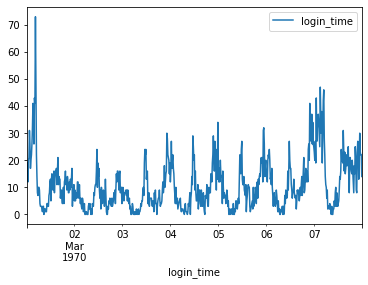

In [14]:
marchweek.plot()

In [15]:
oneday = logins_count.loc['1970-01-28':'1970-01-28']

<AxesSubplot:xlabel='login_time'>

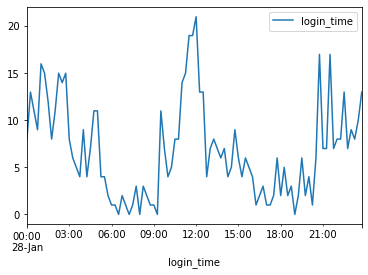

In [16]:
oneday.plot()

# Daily Cycle

I think the chart above is illustrative of a daily cycle where there is a spike in the morning, then during lunch, and then finally late at night. This appears to be the case throughout a whole week, but on the weekends there are larger spikes at night.

In [17]:
logins_day = logins.resample('D', on='login_time').count()

In [18]:
logins_day.head()

,login_time
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


<AxesSubplot:xlabel='login_time'>

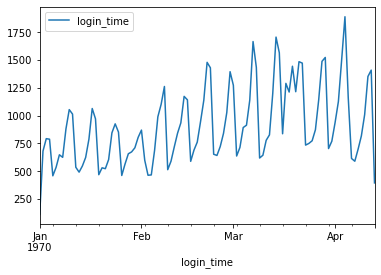

In [19]:
logins_day.plot()

In [20]:
logins_day.describe

<bound method NDFrame.describe of             login_time
login_time            
1970-01-01         112
1970-01-02         681
1970-01-03         793
1970-01-04         788
1970-01-05         459
...                ...
1970-04-09         818
1970-04-10        1009
1970-04-11        1352
1970-04-12        1409
1970-04-13         395

[103 rows x 1 columns]>

In [21]:
logins_day.shape

(103, 1)

In [22]:
onemonth = logins_day.loc['1970-02-01':'1970-02-28']

<AxesSubplot:xlabel='login_time'>

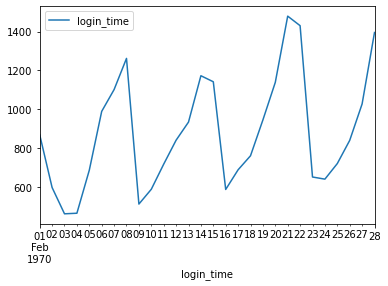

In [23]:
onemonth.plot()

There is also seasonality throughout the month apparently.   I'm not sure why this would be.

# Part 2 - Experiment and Metrics Design

In [24]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [25]:
df['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

# 2.1
I would take the amount of bridge crosses per driver per day before the new policy, and then compare that to the amount of bridge crosses per driver per day after the new policy.  I would think that would be an easy way to see whether or not this new experiment is working.  However with the data above, it appears that we don't have that data.  Absent this data, I think the avg_dist would be the best way to measure this.  We could see how much the distance was before the policy on average, and then see if it changes afterwards.   

# 2.2a
I would take the avg_dist driven per dady before the policy and compare it the avg_dist after.   I would choose this metric because if drivers suddenly started crossing the bridge when they weren't before, this would be a new territory that they would be utilizing each day and it should add to their total distance driven in general.  Theoretically this new territory should drive up avg_dist in general for all users.  

If I had data from the toll bridge, this exercise would be much easier, then I could simply compare toll bridge fees and crossings per driver before to after and this would give me clear data to analyze this problem.

# 2.2b
I could just look at the average numbers, but could also do a hypothesis test to test the null hypothesis that the distances driven were the same before and after the change in policy.

# 2.2c
I would see how statistically different the before and after results were with a null hypothesis test with a p-value of .05. 

# Part 3 - Predictive Modeling

Was a user retained?  I will assume that if they have "trips_in_first_30_days" that we can consider these users retained.

# 3.1

In [26]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


How did signup trends vary over the month?

<AxesSubplot:>

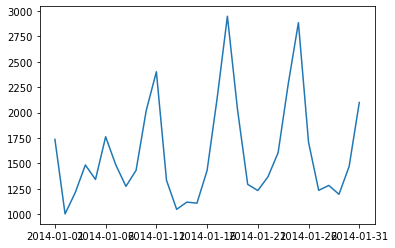

In [27]:
df['signup_date'].value_counts().sort_index().plot()

In [28]:
def Retained(x):
    if x == 0:
        return 0
    else: 
        return 1

In [29]:
df['retained'] = df['trips_in_first_30_days'].apply(Retained)

In [30]:
df['retained'].value_counts()

1    34610
0    15390
Name: retained, dtype: int64

In [31]:
len(df[df['retained']==1])/(len(df[df['retained']==1])+len(df[df['retained']==0]))

0.6922

69% of users were retained by the exercise definition.

In [32]:
df.aggregate(['min', 'max']).T

,min,max
city,Astapor,Winterfell
trips_in_first_30_days,0,125
signup_date,2014-01-01,2014-01-31
avg_rating_of_driver,1,5
avg_surge,1,8
last_trip_date,2014-01-01,2014-07-01
surge_pct,0,100
ultimate_black_user,False,True
weekday_pct,0,100
avg_dist,0,160.96


(array([3.690e+04, 6.350e+03, 2.750e+03, 1.408e+03, 8.200e+02, 5.220e+02,
        3.150e+02, 2.630e+02, 1.930e+02, 1.200e+02, 7.400e+01, 7.800e+01,
        6.700e+01, 3.000e+01, 2.100e+01, 1.700e+01, 1.300e+01, 1.200e+01,
        7.000e+00, 6.000e+00, 7.000e+00, 5.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00, 4.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0.        ,   2.08333333,   4.16666667,   6.25      ,
          8.33333333,  10.41666667,  12.5       ,  14.58333333,
         16.66666667,  18.75      ,  20.83333333,  22.91666667,
         25.        ,  27.08333333,  29.16666667,  31.25      ,
  

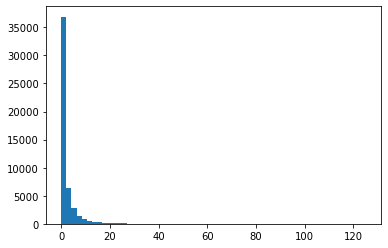

In [33]:
plt.hist(df['trips_in_first_30_days'], bins = 60)

In [34]:
df['trips_in_first_30_days'].value_counts()

0      15390
1      14108
2       7402
3       3788
4       2562
5       1616
6       1134
7        819
8        589
9        471
10       349
11       301
12       221
13       168
15       155
14       147
17       113
16       108
18        80
19        69
20        51
23        45
21        40
22        34
24        33
27        28
28        21
25        20
26        19
30        15
34        11
29         9
33         9
37         9
32         8
31         6
44         5
40         5
38         4
43         4
47         3
42         3
36         3
39         3
53         2
55         2
56         2
54         2
48         2
49         2
35         2
125        1
73         1
58         1
71         1
41         1
50         1
51         1
63         1
Name: trips_in_first_30_days, dtype: int64

In [35]:
column_names = [i for i in df.columns]
print(column_names)

['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver', 'avg_surge', 'last_trip_date', 'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'retained']


In [36]:
for i in column_names:
    print(i), print(df[i].isnull().values.any())

city
False
trips_in_first_30_days
False
signup_date
False
avg_rating_of_driver
True
avg_surge
False
last_trip_date
False
phone
True
surge_pct
False
ultimate_black_user
False
weekday_pct
False
avg_dist
False
avg_rating_by_driver
True
retained
False


In [37]:
nas=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df),columns = ['percent'])
pos = nas['percent'] > 0
nas[pos]

,percent
avg_rating_of_driver,0.16244
phone,0.00792
avg_rating_by_driver,0.00402


The only columns that have blanks are avg rating of driver and avg_rating_by_driver.  I'm going to replace the nulls with the average of all the other ratings in the dataset.  

In [38]:
df['avg_rating_of_driver'].fillna((df['avg_rating_of_driver'].mean()), inplace=True)

In [39]:
df['avg_rating_by_driver'].fillna((df['avg_rating_by_driver'].mean()), inplace=True)

In [40]:
nas=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df),columns = ['percent'])
pos = nas['percent'] > 0
nas[pos]

,percent
phone,0.00792


In [41]:
df = df[df['phone'].notna()]

In [42]:
len(df)

49604

# 3.2

In [43]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1


In [44]:
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
retained                    int64
dtype: object

In [45]:
def active_6th_month(x):
    datee = datetime.datetime.strptime(x, "%Y-%m-%d")
    month = datee.month
    if month == 6:
        return 1
    else:
        return 0

In [46]:
df['6th_month'] = df['last_trip_date'].apply(active_6th_month)

In [47]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,6th_month
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1,0


In [48]:
df['6th_month'].value_counts()

0    31478
1    18126
Name: 6th_month, dtype: int64

I don't need the retained column anymore.

In [49]:
df = df.drop(['retained'], axis=1)

In [50]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,6th_month
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


Modify dataset to create dummies for categorical objects.

In [51]:
df = pd.get_dummies(df, columns=['city'])
df = pd.get_dummies(df, columns=['phone'], drop_first = True)
df = pd.get_dummies(df, columns=['ultimate_black_user'], drop_first = True)

df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,6th_month,city_Astapor,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,1,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,0,0


In [52]:
#Calculate the correlation coefficients

corr = df.corr()
corr.round(2).style.background_gradient(cmap='coolwarm')

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,6th_month,city_Astapor,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
trips_in_first_30_days,1.000000,-0.010000,-0.000000,0.010000,0.050000,-0.140000,-0.040000,0.190000,-0.060000,0.030000,0.040000,0.060000,0.110000
avg_rating_of_driver,-0.010000,1.000000,-0.020000,-0.000000,0.010000,0.030000,0.100000,-0.010000,0.030000,0.080000,-0.090000,-0.020000,-0.000000
avg_surge,-0.000000,-0.020000,1.000000,0.790000,-0.110000,-0.080000,0.010000,-0.000000,0.040000,-0.010000,-0.030000,0.010000,-0.080000
surge_pct,0.010000,-0.000000,0.790000,1.000000,-0.150000,-0.100000,0.020000,0.010000,0.050000,0.030000,-0.070000,0.010000,-0.110000
weekday_pct,0.050000,0.010000,-0.110000,-0.150000,1.000000,0.100000,0.020000,0.000000,-0.010000,0.030000,-0.020000,0.010000,0.040000
avg_dist,-0.140000,0.030000,-0.080000,-0.100000,0.100000,1.000000,0.080000,-0.090000,-0.050000,0.010000,0.030000,-0.020000,0.030000
avg_rating_by_driver,-0.040000,0.100000,0.010000,0.020000,0.020000,0.080000,1.000000,-0.030000,0.030000,0.080000,-0.100000,-0.010000,0.010000
6th_month,0.190000,-0.010000,-0.000000,0.010000,0.000000,-0.090000,-0.030000,1.000000,-0.170000,0.250000,-0.050000,0.220000,0.200000
city_Astapor,-0.060000,0.030000,0.040000,0.050000,-0.010000,-0.050000,0.030000,-0.170000,1.000000,-0.350000,-0.660000,-0.030000,0.020000
city_King's Landing,0.030000,0.080000,-0.010000,0.030000,0.030000,0.010000,0.080000,0.250000,-0.350000,1.000000,-0.470000,0.060000,0.040000


None of the columns seem to be very correlated with whether or not the passenger will be active in their 6th month.  Trips in the first 30 days seems to be the best indicator of this.  Iphone users, users from King's Landing, or Astapor, and ultimate Black users seem to be the factors most correlated with whether or not the passenger will be active in their 6th month. 

So I'm going to build a logistic regression model and a decision tree model and see which gives me better predictive power based on the 3 variables identified above.

In [53]:
y = df['6th_month']

In [54]:
X = df[['trips_in_first_30_days','city_Astapor', "city_King's Landing", 'city_Winterfell', 'phone_iPhone', 'ultimate_black_user_True']]

In [55]:
X.head()

,trips_in_first_30_days,city_Astapor,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,4,0,1,0,1,1
1,0,1,0,0,0,0
2,3,1,0,0,1,0
3,9,0,1,0,1,1
4,14,0,0,1,0,0


# Logistic Regression Model

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y,random_state=5)

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.7126038222723974


In [57]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# your turn
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegressionCV

for i in Cs:
    clf = LogisticRegressionCV(Cs=[i], max_iter= 1000, random_state=0).fit(Xlr, ylr)
    clf.predict(Xlr)
    print(i,clf.score(Xlr,ylr))

0.001 0.7080880574147246
0.1 0.7170658280246217
1 0.716985189366449
10 0.716985189366449
100 0.716985189366449


In [58]:
from sklearn.model_selection import GridSearchCV

grid = {'C': [0.001, 0.1, 1, 10, 100]}

clf = GridSearchCV(LogisticRegression(), grid)

clf.fit(Xlr, ylr)

print(clf.best_params_)

print(accuracy_score(clf.predict(Xtestlr), ytestlr))

{'C': 0.1}
0.7125231836142246


In [59]:
# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y,random_state=5)

clf = LogisticRegression(C=.1)
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.7125231836142246


# Decision Tree Model

Model Entropy model - no max_depth

In [60]:
#!pip install pydotplus

In [61]:
#!pip install sklearn.externals.six

In [62]:
from IPython.display import Image  
import pydotplus
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=246)

In [64]:

entr_model = tree.DecisionTreeClassifier(criterion="entropy", random_state = 1234)

# Call fit() on entr_model
entr_model.fit(X_train, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 

y_pred = entr_model.predict(X_test)

# Call Series on our y_pred variable with the following: pd.Series(y_pred)
pd.Series(y_pred)

# Check out entr_model
entr_model

DecisionTreeClassifier(criterion='entropy', random_state=1234)

In [69]:
# Run this block for model evaluation metrics 
print("Model Entropy - no max depth")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Precision score for "No"' , metrics.precision_score(y_test,y_pred, pos_label = 0))
print('Recall score for "Yes"' , metrics.recall_score(y_test,y_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test,y_pred, pos_label = 0))

Model Entropy - no max depth
Accuracy: 0.7284896379324248
Balanced accuracy: 0.6773995559855844
Precision score for "Yes" 0.6721411192214112
Precision score for "No" 0.7488203665093822
Recall score for "Yes" 0.4912202711713714
Recall score for "No" 0.8635788407997975


# 3.3

Ultimate can use the Decision tree model with an accurate of .728 in order to improve it's long-term rider retention.  Retention is going to be based on the City of the user.  Iphone users and ultimate Black Users are more likely to continue to be using the service in June.  An accuracy of .728 is not overly strong, but if we did some more hyperparameter tunign we maybe could make it more accurate.    